## Analyzing GA repeats in GAF-degron Hi-C data

### Main question: Do GA-repeats exhibit compartment switching when GAF is degraded

### General outline:
- Identify reads where one end contains a (AAGAG)x5 repeat
- Map the other end of GA-repeat-containing reads, select those that map uniquely
- Determine whether there is a shift among these reads from A -> B or B -> A

*Identifying GA-repeat-containing reads is accomplished outside this notebook by sort_GArepeats.py. The complimentary reads are then mapped using bowtie via my script hic_iterative_mapping_bowtie.py. Subsequent processing is done in this notebook.*

To dos:
- Chromosome contact 1D map
- Contacts vs. comp. score
- collapse mapping file.
- control random sampling of mapping

In [1]:
from Bio import SeqIO
import gzip
import re
import numpy as np
import matplotlib.pyplot as plt
import stadc as sc

In [70]:
# Functions.

from re import X


def count_bins(filepath, bin_size=25_000, max_chr_size=5e7):
    """Converts unique mapping file to binned counts (1D) for each chromosome.
    
    Args:
        filepath: str
            path to a bowtie alignment file with only unique reads
        bin_size: int
            Size in bp of bins
        max_chr_size: int
            Maximum size in bp allowable for chromosome (for memory alloc)

    Returns:
        bincounts: dict of ndarrays
            keys are chromosome names, arrays are bin counts (0-indexed)
        maxbins: dict
            keys are chromosome names, values are the maximum 0-indexed
            bin number oberved in the data for that chromosome
    """
    chroms = ['X', '2L', '2R', '3L', '3R']
    bincounts = {}
    maxbins = {}
    locs_seen = {}

    for c in chroms:
        bincounts[c] = np.zeros(round(max_chr_size / bin_size))
        maxbins[c] = 0
        locs_seen[c] = set()

    with open(filepath, 'r') as infile:
        for line in infile:
            line = line.rstrip()
            items = line.split('\t')
            chrom = items[2]
            pos = int(items[3])
            bin_num = int(pos / bin_size)
            if chrom in chroms:
                if pos not in locs_seen[chrom]:
                    bincounts[chrom][bin_num] += 1
                    if bin_num > maxbins[chrom]:
                        maxbins[chrom] = bin_num
                    locs_seen[chrom].add(pos)
    return bincounts, maxbins

#---------------------------------------------------------------------------
def process_plot_compartments(mat, start, end, plot=True):
    """Makes compartment vector from a supplied contact matrix file.
    
    Compartment vector is the 1st eigenvector of centered covariance matrix of
    distance-normalized contact matrix. Details are contained 
    within functions in stadc library.

    Args:
        mat: ndarray
            Raw counts matrix for a chromosome, chromosome arm, or region
        start: int
            First bin to include
        end: int
            Last bin to include
        plot: bool
            Whether to plot the contact matrix with compartment vector

    Returns:
        comp: ndarray
            Vector of compartment score (first eigenvector)
    """
    m = mat[start:end, start:end]
    m_norm = sc.norm_hic_matrix(m)
    distnorm = sc.distnorm(m_norm)
    centered, pca, X = sc.pca_matrix(distnorm)
    comp = np.linalg.eig(centered)[1][:,0]

    if plot:
        sc.plot_compartments(centered, X, invert=True)
    
    return comp

#---------------------------------------------------------------------------
def plot_1D_counts(bincounts1, bincounts2, maxbins, chrom, start=None, end=None):
    def process_bincounts(bc):
        x = bc[chrom] + 0.5
        x = x[:maxbins[chrom]]
        x = x / np.mean(x)
        return x

    plt.subplots(figsize=(15,5))
    x1 = process_bincounts(bincounts1)
    x2 = process_bincounts(bincounts2)
    if (start is not None) and (end is not None):
        x1 = x1[start:end]
        x2 = x2[start:end]

    plt.plot(np.log(x1), linewidth=3)
    plt.plot(np.log(x2), linewidth=3)
    print(np.sum(bincounts1[chrom]), np.sum(bincounts2[chrom]))
    return x1, x2

#---------------------------------------------------------------------------
def plot_compartment_vs_foldchange(bincounts1, bincounts2, comp):
    if (len(bincounts1) != len(bincounts2)) or (len(bincounts1) != len(comp)):
        raise ValueError('All three vectors must be the same length')
    foldchange = np.log(bincounts1 / bincounts2)
    plt.scatter(foldchange, comp)

[0.96268588 0.02119193]
2555.0 1470.0


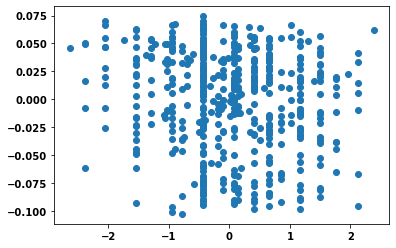

In [94]:
bin_size = 25_000
chrom = 'X'
start = 200
end = 700
bowtie1 = '/Users/michaelstadler/Bioinformatics/Projects/insulators/data/mapping/GAreps/HiC-66_GAcomp_combined_unique.bowtie'
bowtie2 = '/Users/michaelstadler/Bioinformatics/Projects/insulators/data/mapping/GAreps/HiC-67_GAcomp_combined_unique.bowtie'
matrix_file_stem = '/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-57_binCounts_25kB_chr' 


bc1, maxbins = count_bins(bowtie1, bin_size)
bc2, _ = count_bins(bowtie2, bin_size)
mat = np.loadtxt(matrix_file_stem + chrom + '.txt.gz')
comp = process_plot_compartments(mat, start, end, plot=True);
plt.savefig("/Users/michaelstadler/Bioinformatics/Projects/insulators/data/figure_data/1.png")
plt.close()
bc1_normed, bc2_normed = plot_1D_counts(bc1, bc2, maxbins, chrom, start, end);
plt.tight_layout()
plt.savefig("/Users/michaelstadler/Bioinformatics/Projects/insulators/data/figure_data/2.png")
plt.close()
plot_compartment_vs_foldchange(bc1_normed, bc2_normed, comp)

plt.savefig("/Users/michaelstadler/Bioinformatics/Projects/insulators/data/figure_data/3.png")


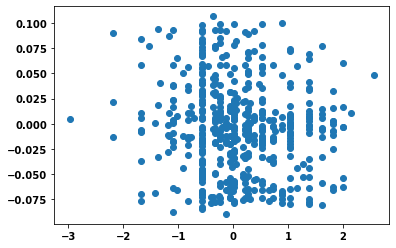

In [88]:
plot_compartment_vs_foldchange(bc1_normed, bc2_normed, comp)

[0.92288388 0.03980696]
5536.0 2814.0


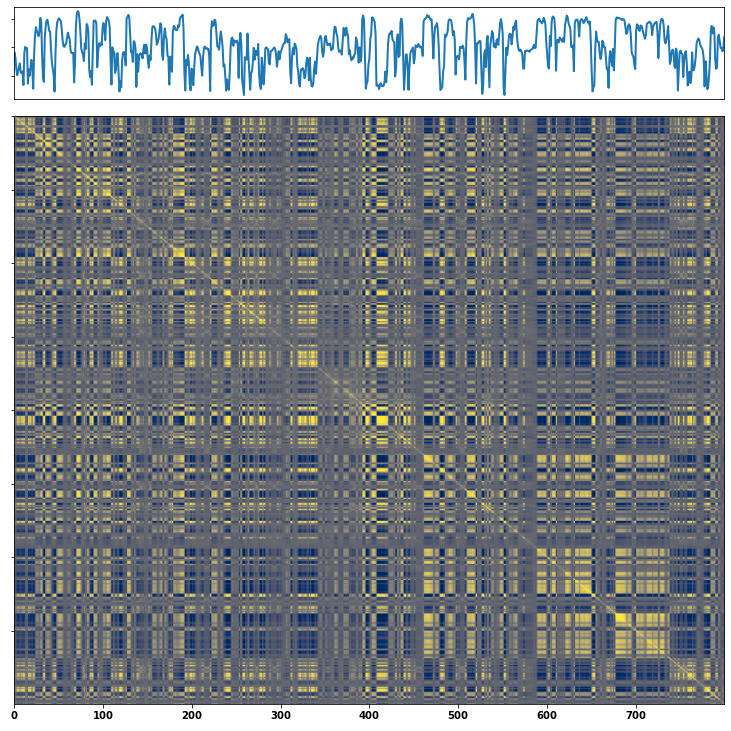

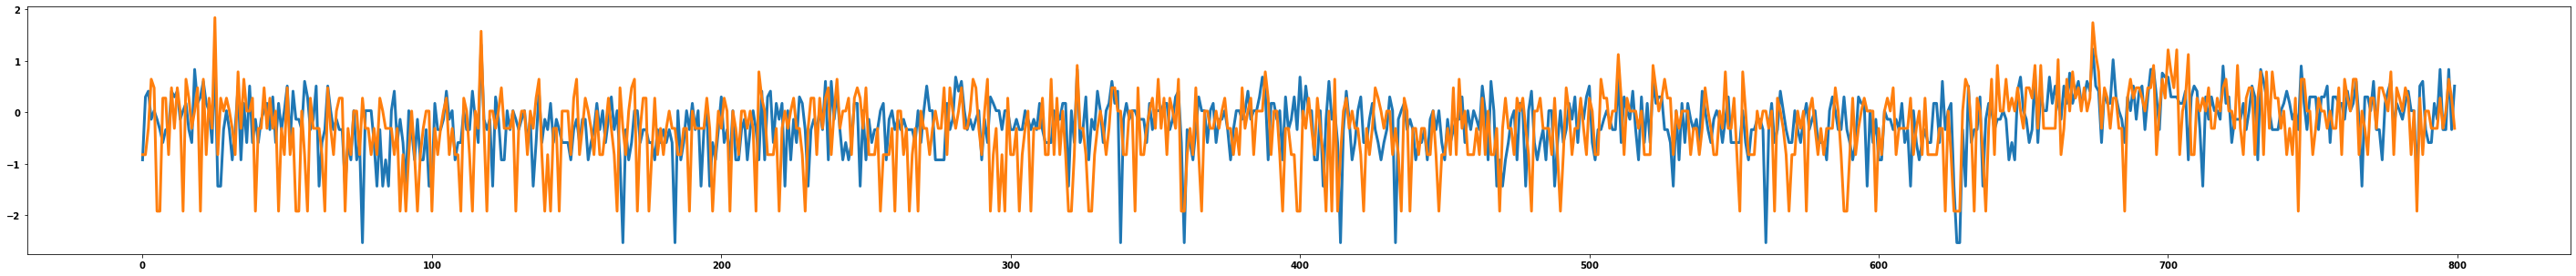

In [60]:
bc1, maxbins = count_bins(bowtie1, bin_size)
bc2, _ = count_bins(bowtie2, bin_size)
mat = np.loadtxt(matrix_file_stem + chrom + '.txt.gz')
comp = process_plot_compartments(mat, start, end, plot=True);
bc1_normed, bc2_normed = plot_1D_counts(bc1, bc2, maxbins, chrom, start, end)
plot_compartment_vs_foldchange(bc1_normed, bc2_normed, comp)

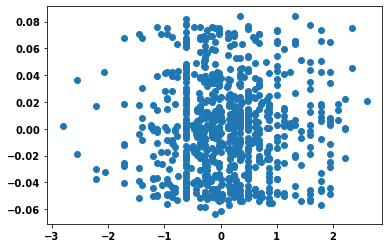

In [66]:
np.log(0.5 / 1)

-0.6931471805599453

[0.92288388 0.03980696]


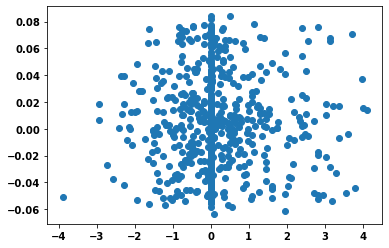

In [130]:
chrom='X'
bincounts1 = bc_66
bincounts2 = bc_67
start=0
stop=800

mat = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-57_binCounts_25kB_chr' + chrom + '.txt.gz')
comp = process_plot_compartments(m_2L, start, stop, plot=False);

ratio = (bincounts1[chrom] + 0.5) / (bincounts2[chrom] + 0.5)
logratio = np.log(ratio)[start:stop]

plt.scatter(logratio, comp)